# W.2. Black-Derman-Toy

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Modeling the Rate

We need a model for interest rate.
* It is not a traded security.
* Should we allow the model to be negative?

Without a model, we run into problems with our binomial tree:
* How do we build the nodes for $r$?
* Matching volatility and using up/down factors leads to problems.
* In particular, the $p^*$ required to fit the current market price may be outside $(0,1)$.

### Dynamics of the Interest Rate

In theory, we could estimate a regression of interest rate data to better understand its evolution in terms of 
* drift
* volatility

But this would not be enough to price derivatives.

Valuation depends on 
* **natural** expected cashflows discounted by risk premia and time
* **risk-neutral** expected cashflows discounted by time

With the natural dynamics of interest rates, we would still be left to estimate risk premia used in discounting cashflows.

Rather, we want to directly model the **risk-neutral** dynamics of the interest-rate process, with little reference to the natural dynamics.

### Twisting the State Space

Earlier, we have seen binomial trees with given states and a derived (fitted) risk-neutral probability, $p^*_t$.

Equivalently, we can set the risk-neutral probabilities to all be constant at a convenient number, $p^*_t=0.5$, and then derive (fit) the state space.

Most modern binomial tree approaches in fixed-income take this approach.

Thus, in the models below, we use $p^*=0.5$.

### Two Common Paths

1. Normal models
2. Lognormal models

Though we are using a discrete-time binomial tree, we'll see that these approaches arise in a discretization of popular models for $r$ as a stochastic processes.

# Risk-Neutral Interest-Rate Dynamics

### Ho-Lee
In the Ho-Lee model, the (short) interest rate evolves along the tree as follows:

$$
\begin{align*}
r_{s,t+1} =& r_{s,t} + \theta_t\Delta_t + \sigma\sqrt{\Delta_t}\\
r_{s+1,t+1} =& r_{s,t} + \theta_t\Delta_t - \sigma\sqrt{\Delta_t}\\
\end{align*}
$$

### (Constant Vol) Black-Derman-Toy
In the Black-Derman-Toy model, the **logarithim** of the (short) interest rate evolves along the tree as follows:
$$
\begin{align*}
z_{s,t+1} =& z_{s,t} + \theta_t\Delta_t + \sigma\sqrt{\Delta_t}\\
z_{s+1,t+1} =& z_{s,t} + \theta_t\Delta_t - \sigma\sqrt{\Delta_t}\\
r_{s,t} = & \frac{1}{100}e^{z_{s,t}}
\end{align*}
$$

### Time-varying Drift
Note that the drift of the rate is controlled by the parameter, $\theta_t$.
* These are the risk-neutral dynamics. Shouldn't the drift equal zero?

How do we set this parameter?
* Set each $\theta_t$ such that it correctly fits the discount rates extracted from a base asset, (usually Treasury bonds, swaps, etc.)

### Volatility

We return to this parameter $\sigma$ with regard to how we might fit it and generalize it.

### Pricing
Once we have the interest-rate tree, pricing proceeds as usual with binomial trees.
* But we have the nodes of the interest rate modeled.
* And we have $p^*=0.5$ at all nodes.

# Example

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from binomial import *

In [2]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

### Data on zero-coupon bonds
Maturities out to 5.5 years.

In [3]:
dt = .5
T = 5
sigmaval = .2142


rawdata = np.array([99.1338,
         97.8925,
         96.1462,
         94.1011,
         91.7136,
         89.2258,
         86.8142,
         84.5016,
         82.1848,
         79.7718,
         77.4339])

quotes = pd.Series(rawdata, index=np.arange(dt,T+2*dt,dt))
quotes.to_frame().T

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5
0,99.1338,97.8925,96.1462,94.1011,91.7136,89.2258,86.8142,84.5016,82.1848,79.7718,77.4339


In [4]:
ratetree = construct_rate_tree(dt=.5, T=5)
format_bintree(ratetree, style='{:.2%}')

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
state,,,,,,,,,,,
0,,,,,,,,,,,
1,,,,,,,,,,,
2,,,,,,,,,,,
3,,,,,,,,,,,
4,,,,,,,,,,,
5,,,,,,,,,,,
6,,,,,,,,,,,
7,,,,,,,,,,,
8,,,,,,,,,,,


In [5]:
theta = pd.Series(dtype=float, index=ratetree.columns)
dt = ratetree.columns[1] - ratetree.columns[0]

for tsteps, t in enumerate(ratetree.columns):    
    if tsteps==0:
        ratetree.loc[0,0] = -np.log(quotes.iloc[tsteps]/100)/dt
    else:
        subtree = ratetree.iloc[:tsteps+1,:tsteps+1]
        wrapper = lambda theta: incremental_BDT_pricing(subtree, theta, sigmaval).loc[0,0] - quotes.iloc[tsteps]
        theta.iloc[tsteps-1] = fsolve(wrapper,.5)[0]
        ratetree.loc[:,t] = incrementBDTtree(subtree, theta.iloc[tsteps-1], sigmaval).loc[:,t]

In [6]:
format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
0,71.83%,69.15%,33.48%,33.78%,11.83%,-2.30%,-4.38%,4.55%,12.81%,-1.26%,


In [7]:
format_bintree(ratetree,style='{:.2%}')

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
state,,,,,,,,,,,
0,1.74%,2.90%,4.77%,6.56%,9.03%,11.15%,12.83%,14.60%,17.38%,21.56%,24.93%
1,,2.14%,3.52%,4.84%,6.67%,8.24%,9.47%,10.79%,12.84%,15.92%,18.41%
2,,,2.60%,3.58%,4.93%,6.08%,7.00%,7.97%,9.48%,11.76%,13.60%
3,,,,2.64%,3.64%,4.49%,5.17%,5.88%,7.00%,8.69%,10.05%
4,,,,,2.69%,3.32%,3.82%,4.35%,5.17%,6.42%,7.42%
5,,,,,,2.45%,2.82%,3.21%,3.82%,4.74%,5.48%
6,,,,,,,2.08%,2.37%,2.82%,3.50%,4.05%
7,,,,,,,,1.75%,2.09%,2.59%,2.99%
8,,,,,,,,,1.54%,1.91%,2.21%


# Pricing Derivatives

### Caplets and Floorlets

A **caplet** is a derivative with the following payoff:
$$ N\Delta_t\max(r_n-K,0)$$
where
* $N$ is the notional
* $K$ is the strike, which is an interest rate.
* $r_n$ is the $n$-times compounded interest rate.
* $\Delta_t$ is the frequency of the payments, $\Delta_t = \frac{1}{n}$

A **floorlet** is a derivative with the following payoff:
$$ N\Delta_t\max(K-r_n,0)$$

One could think of the caplet as a *call* option on an interest rate and the floorlet as a *put*.
* Like a vanilla call option in equities, a caplet is a benchmark derivative for fixed income.
* We will see that it is the basis of many model parameterizations.

### Example

In Homework \#1 you priced a caplet. 

Try this pricing with the BDT model...
* $N=100$
* $K=.02$
* $T=1.5$
* $n=2$
* $dt=.5$

In [8]:
STRIKE = .02
N = 100
T = 1.5

tsteps = int(T/dt) + 1
compound = int(1/dt)

### Careful

The underlying for the derivative may differ from the continuously-compounded rate modeled in the tree.

For this cap:
* BDT models continuously-compounded rate, $r$
* Derivative depends on the semiannually compounded rate.

Build the tree of reference rates:

In [9]:
refratetree = compound * (np.exp(ratetree / compound)-1)
format_bintree(refratetree.iloc[:tsteps,:tsteps], style='{:.2%}')

time,0.00,0.50,1.00,1.50
state,,,,
0,1.75%,2.92%,4.82%,6.67%
1,,2.15%,3.55%,4.90%
2,,,2.62%,3.61%
3,,,,2.66%


Below, we 
* build cashflows with the referenced rate
* discount with the continuously compounded rates

We could discount with the (equivalent) referenced, compounded rate.
* but easier to have the code / procedure always discount with the modeled continuously-compounded rate.

In [10]:
payoff = lambda r: N * dt * np.maximum(r-STRIKE,0)
bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree=refratetree.iloc[:tsteps,:tsteps]).style.format('{:.2f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50,1.00,1.50
state,,,,
0,1.13,1.46,1.85,2.33
1,,0.83,1.11,1.45
2,,,0.56,0.80
3,,,,0.33


### A floorlet

Continue with the same parameters, but this time for a floorlet.

In [11]:
payoff = lambda r: N * dt * np.maximum(STRIKE-r,0)
format_bintree(bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree=refratetree.iloc[:tsteps,:tsteps]))

time,0.00,0.50,1.00,1.50
state,,,,
0,0.00,0.00,0.00,0.00
1,,0.00,0.00,0.00
2,,,0.00,0.00
3,,,,0.00


# Caps and Floors

The most frequent way to encounter caplets and floorlets is as the components of **caps** and **floors**. (Thus the name.)

A **cap** is a portfolio of caplets
* each with the same strike, $K$
* at a sequence of caplet maturities

Similarly for a **floor**.

Markets trade and price these *portfolios* such that we must consider them in a bit more detail.

### Payment in Arrears

It is important to note that *in contrast to our simple caplet/floorlet example above*, the cap and floor make payments on a reference rate in arrears:

$$C_{i+1} = N\Delta_t\max(r_{n,i}-K)$$
where 
* $r_{n,i}$ denotes the $n$-compounded rate as of period $i$. 
* $C_{i+1}$ denotes the cashflow paid/received in period $i+1$.

This means that each payoff determined at time $t$ pays out one period later, (whether that period is a quarter, half-year, or year.)

This has two important implications:

1. The first caplet is missing from the cap! 
* That is, a semiannually-paying cap with expiration at $T=3$ will not include a caplet expiring at $T=.5$. The first caplet will expire at $T=1$.
* Why?

2. When pricing the cap, one must be careful to discount the final payoff by the risk-free rate.
* Why?

And similarly for floors.

## Example

Consider the following example of a cap with:

* $K=.04$
* $T=5$
* $n=2, \Delta_t=.5$
* $N=100$

In [12]:
STRIKE = .04
N = 100
T=5

tsteps = int(T/dt)

In [13]:
refratetree = compound * (np.exp(ratetree / compound)-1)
format_bintree(refratetree.iloc[:tsteps,:tsteps],style='{:.2%}')

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50
state,,,,,,,,,,
0,1.75%,2.92%,4.82%,6.67%,9.24%,11.47%,13.25%,15.15%,18.16%,22.76%
1,,2.15%,3.55%,4.90%,6.79%,8.41%,9.70%,11.08%,13.26%,16.58%
2,,,2.62%,3.61%,4.99%,6.18%,7.12%,8.13%,9.71%,12.12%
3,,,,2.66%,3.67%,4.55%,5.24%,5.97%,7.13%,8.88%
4,,,,,2.71%,3.35%,3.86%,4.39%,5.24%,6.52%
5,,,,,,2.47%,2.84%,3.24%,3.86%,4.80%
6,,,,,,,2.09%,2.39%,2.84%,3.53%
7,,,,,,,,1.76%,2.10%,2.60%
8,,,,,,,,,1.55%,1.92%


In [14]:
payoff = lambda r: N * dt * np.maximum(r-STRIKE,0)

cftree = payoff(refratetree.iloc[:tsteps,:tsteps])
format_bintree(cftree)

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50
state,,,,,,,,,,
0,0.00,0.00,0.41,1.33,2.62,3.73,4.62,5.57,7.08,9.38
1,,0.00,0.00,0.45,1.39,2.20,2.85,3.54,4.63,6.29
2,,,0.00,0.00,0.50,1.09,1.56,2.06,2.86,4.06
3,,,,0.00,0.00,0.27,0.62,0.99,1.56,2.44
4,,,,,0.00,0.00,0.00,0.20,0.62,1.26
5,,,,,,0.00,0.00,0.00,0.00,0.40
6,,,,,,,0.00,0.00,0.00,0.00
7,,,,,,,,0.00,0.00,0.00
8,,,,,,,,,0.00,0.00


In [15]:
format_bintree(bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= refratetree.iloc[:tsteps,:tsteps], cftree=cftree, timing='deferred'),style='{:.3f}')

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50
state,,,,,,,,,,
0,4.975,7.091,9.924,12.851,15.105,16.259,16.332,15.347,13.012,8.423
1,,2.945,4.465,6.651,8.787,10.106,10.582,10.234,8.859,5.807
2,,,1.489,2.438,3.939,5.278,6.072,6.254,5.662,3.826
3,,,,0.579,1.024,1.808,2.632,3.199,3.228,2.336
4,,,,,0.149,0.279,0.520,0.966,1.390,1.221
5,,,,,,0.023,0.046,0.094,0.191,0.389
6,,,,,,,0.000,0.000,0.000,0.000
7,,,,,,,,0.000,0.000,0.000
8,,,,,,,,,0.000,0.000


### Floor

Try a floor with the same parameters.

In [16]:
payoff = lambda r: N * dt * np.maximum(STRIKE-r,0)

cftree = payoff(refratetree.iloc[:tsteps,:tsteps])
format_bintree(cftree)

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50
state,,,,,,,,,,
0,1.13,0.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,0.92,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,0.69,0.20,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,0.67,0.16,0.00,0.00,0.00,0.00,0.00
4,,,,,0.65,0.33,0.07,0.00,0.00,0.00
5,,,,,,0.77,0.58,0.38,0.07,0.00
6,,,,,,,0.95,0.81,0.58,0.23
7,,,,,,,,1.12,0.95,0.70
8,,,,,,,,,1.23,1.04


In [17]:
format_bintree(bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= refratetree.iloc[:tsteps,:tsteps], cftree=cftree, timing='deferred'),style='{:.3f}')

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50
state,,,,,,,,,,
0,2.776,0.881,0.043,0.005,0.000,0.000,0.000,0.000,0.000,0.000
1,,2.467,0.666,0.084,0.010,0.000,0.000,0.000,0.000,0.000
2,,,2.474,0.824,0.161,0.021,0.000,0.000,0.000,0.000
3,,,,2.807,1.126,0.310,0.043,0.000,0.000,0.000
4,,,,,3.224,1.658,0.590,0.089,0.000,0.000
5,,,,,,3.584,2.129,0.969,0.182,0.000
6,,,,,,,3.596,2.189,1.023,0.230
7,,,,,,,,3.171,1.793,0.689
8,,,,,,,,,2.365,1.030


***

# Swap

We can decompose swaps into a fixed and floating rate bonds, as in FINM 37400.

Still, it is useful to demonstrate that the methods we are using can price any interest-rate derivative--not just options.

Furthermore, having the tree of swap value swill be useful for **swaptions**.

Consider the following parameters:
* swap rate $K=.05$
* maturity $T=5$
* semiannual compounding and frequency

Note that the swap is like the caps and floors in that the payments are based on the previous period's interest rate.

That is, the payoff at time period $i$ is
$$C_{i+1} = N\Delta_t(r_{n,i}-K)$$
where 
* $C_{i+1}$ is the cashflow at period $i+1$ 
* $r_{n,i}$ is the n-frequency compounded rate at period $i$.
* $K$ is the swap rate

In [18]:
STRIKE = .05
N = 100
T=5

tsteps = int(T/dt)

In [19]:
payoff = lambda r: N * dt * (r-STRIKE)

cftree = payoff(refratetree.iloc[:tsteps,:tsteps])
format_bintree(cftree)

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50
state,,,,,,,,,,
0,-1.63,-1.04,-0.09,0.83,2.12,3.23,4.12,5.07,6.58,8.88
1,,-1.42,-0.72,-0.05,0.89,1.70,2.35,3.04,4.13,5.79
2,,,-1.19,-0.70,-0.00,0.59,1.06,1.56,2.36,3.56
3,,,,-1.17,-0.66,-0.23,0.12,0.49,1.06,1.94
4,,,,,-1.15,-0.83,-0.57,-0.30,0.12,0.76
5,,,,,,-1.27,-1.08,-0.88,-0.57,-0.10
6,,,,,,,-1.45,-1.31,-1.08,-0.73
7,,,,,,,,-1.62,-1.45,-1.20
8,,,,,,,,,-1.73,-1.54


In [20]:
swaptree = bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= refratetree.iloc[:tsteps,:tsteps], cftree=cftree, timing='deferred')
format_bintree(swaptree)

time,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50
state,,,,,,,,,,
0,-2.31,2.23,6.40,9.84,12.56,14.14,14.63,14.05,12.14,7.97
1,,-3.63,0.19,3.44,6.12,7.89,8.80,8.89,7.95,5.35
2,,,-4.69,-1.60,1.04,2.97,4.24,4.87,4.73,3.35
3,,,,-5.52,-2.91,-0.84,0.71,1.79,2.28,1.86
4,,,,,-5.93,-3.76,-1.98,-0.56,0.43,0.74
5,,,,,,-5.97,-4.01,-2.33,-0.96,-0.10
6,,,,,,,-5.54,-3.65,-2.00,-0.72
7,,,,,,,,-4.64,-2.78,-1.18
8,,,,,,,,,-3.35,-1.53


The swap has negative value today.
* It had value of zero at initialization.
* So in this example, the rates have gone lower than the swap rate in the contract, $K$, giving value to the swap receiver.
* We are valuing for the swap payer, so the valuation is negative.

# Swaptions

A **receiver swaption** is 
* a contract today, (with a price paid today)
* for the option, not obligation,
* to enter into a swap **receiving** the swap rate, (set today, like a strike,)
* from $T_1$ to $T_2$.

Thus, the **receiver swaption** is like a **put** on a swap.

A **payer swaption** is the same thing, but the option is to enter into the swap, **paying** the swap rate (strike). Thus, it is like the **call** on a swap.

Of course, being short the **receiver** swaption is not the same thing as being long the **payer** swaption.

### Timing

Note that we have three dates to consider: 
* the option expiration
* the swap start date
* the swap end date

A plain swaption sets the swap to start at the time the option expires.

Thus, a 2\% 1Y$\rightarrow$10Y denotes
* 2\% strike
* swaption with expiration of 1 year
* for a swap starting in 1 year and ending 10 years thereafter (in 11 years)

## Midcurve Swaptions

Suppose that the date of (underlying) swap beginning is **after** the swaption expires. 

This is a **midcurve** swaption.

Could have a 6m$\rightarrow$1Y$\rightarrow$5Y midcurve swaption:
* expires in 6 months
* underlying swap starts one year after that expiration (in 1.5 years from today)
* swap runs for 5 years, (until 6.5 years from today.)

In [21]:
T = 2
tsteps = int(T/dt)+1

payoff = lambda v: np.maximum(v,0)

swaptreeT = swaptree.iloc[:tsteps,:tsteps]

swaption_tree = bintree_pricing(payoff=payoff,  ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= swaptreeT)
format_bintree(swaption_tree)

time,0.00,0.50,1.00,1.50,2.00
state,,,,,
0,2.52,3.98,6.12,9.04,12.56
1,,1.10,1.97,3.49,6.12
2,,,0.25,0.51,1.04
3,,,,0.00,0.00
4,,,,,0.00


### American Swaption

In [22]:
swaption_tree_Amer = bintree_pricing(payoff=payoff,  ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= swaptreeT,style='american')
format_bintree(swaption_tree_Amer)

time,0.00,0.50,1.00,1.50,2.00
state,,,,,
0,2.61,4.18,6.51,9.84,12.56
1,,1.10,1.97,3.49,6.12
2,,,0.25,0.51,1.04
3,,,,0.00,0.00
4,,,,,0.00


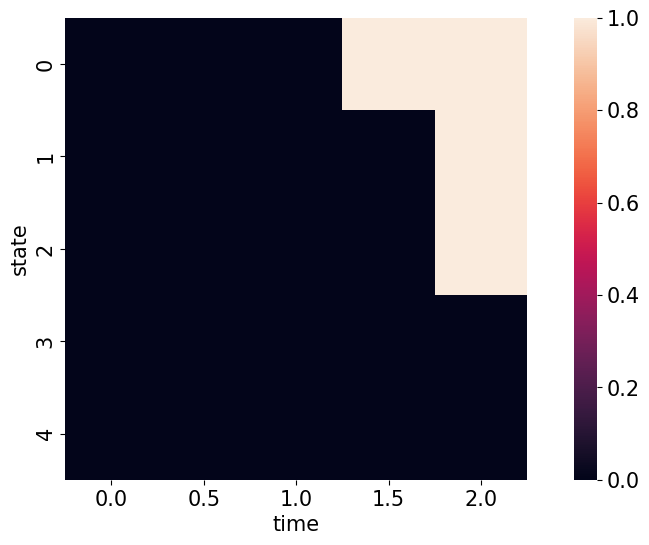

In [23]:
sns.heatmap(exercise_decisions(payoff,undertree=swaptreeT, derivtree=swaption_tree_Amer),square=True);